# Optimizers and Schedulers

> In this module, we reimplement gradient descent and its variants and explore learning rate scheduling. We discuss the relationship between learning rate scheduling and intialization.

Adapted from:

- [https://youtu.be/vGsc_NbU7xc?si=xn-rYgIuG1j4r9ll&t=5348](https://youtu.be/vGsc_NbU7xc?si=xn-rYgIuG1j4r9ll&t=5348)

In [1]:
#| default_exp sgd

In [2]:
# |export
from functools import partial

import fastcore.all as fc
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torchmetrics.classification import MulticlassAccuracy

from slowai.activations import StoreModuleStatsCB, set_seed
from slowai.initializations import (
    CNNWithGeneralReLUAndBatchNorm,
    GeneralReLU,
    init_leaky_weights,
    set_seed,
)
from slowai.learner import (
    Callback,
    DeviceCB,
    MetricsCB,
    MomentumCB,
    ProgressCB,
    TrainLearner,
    fashion_mnist,
)
from slowai.utils import glomf as g

In [3]:
set_seed(42)
plt.style.use("ggplot")

In [4]:
# |export
def train(model, lr, n_epochs=3, bs=512, opt_func=torch.optim.SGD, cbs=tuple()):
    """Train a Fashion MNIST model"""
    cbs_ = [
        MetricsCB(MulticlassAccuracy(num_classes=10)),
        DeviceCB(),
        ProgressCB(plot=True),
    ]
    if cbs:
        cbs_.extend(cbs)
    TrainLearner(
        model,
        fashion_mnist(bs),
        F.cross_entropy,
        lr=lr,
        cbs=cbs_,
        opt_func=opt_func,
    ).fit(n_epochs)

This was the best model from the previous notebook at 88% accuracy. We're going to make this better!

In [5]:
def get_kaiming_initalized_model(leak=0.1):
    model = CNNWithGeneralReLUAndBatchNorm(gr=partial(GeneralReLU, leak=leak))
    model.apply(partial(init_leaky_weights, leak=leak))
    return model

MulticlassAccuracy,loss,epoch,train
0.791,0.578,0,train
0.807,0.531,0,eval
0.855,0.395,1,train
0.835,0.460,1,eval
0.868,0.357,2,train
0.841,0.443,2,eval


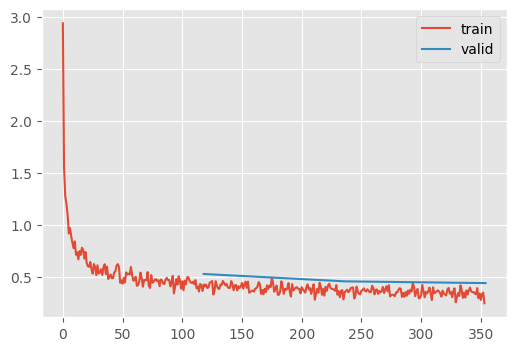

MulticlassAccuracy,loss,epoch,train
0.883,0.321,0,train
0.868,0.358,0,eval
0.886,0.314,1,train
0.869,0.355,1,eval


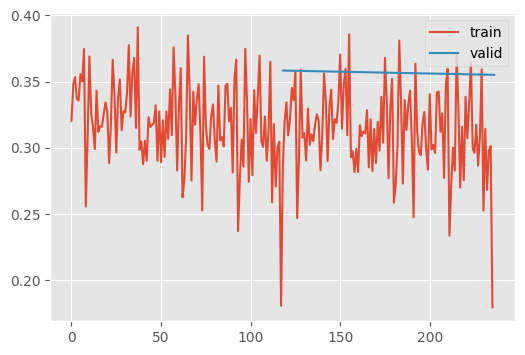

In [6]:
model = get_kaiming_initalized_model()
train(model, lr=0.2, n_epochs=3, cbs=[MomentumCB()])
train(model, lr=0.05, n_epochs=2, cbs=[MomentumCB()])

## Implementing Stochastic Gradient Descent

Let's start to implement our own optimizer class. Remember, the learner class interfaces with the optimizer solely through the constructor and the `step` function. 

```python
@with_cbs("batch")
def _one_batch(self):
    self.predict()
    self.callback("after_predict")
    self.get_loss()
    self.callback("after_loss")
    if self.training:
        self.backward()
        self.callback("after_backward")
        self.step() # 👈
        self.callback("after_step")
        self.zero_grad()
# ...

def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
    with tempfile.TemporaryDirectory() as tdir:
        self.dls.tdir = tdir
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs:
            self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None:
                lr = self.lr
            if self.opt_func:
                self.opt = self.opt_func(self.model.parameters(), lr) # 👈
            self._fit(train, valid)
        finally:
            for cb in cbs:
                self.cbs.remove(cb)
```

Therefore, we only need to implement those two interfaces. Let's also add (and discuss) weight decay.

In [7]:
class SGD:
    def __init__(self, params, lr, wd=0):
        params = list(params)
        fc.store_attr()
        self.i = 0

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1

    def opt_step(self, p):
        p -= p.grad * self.lr

    def reg_step(self, p):
        if self.wd != 0:
            p *= 1 - self.lr * self.wd

    def zero_grad(self):
        for p in self.params:
            p.grad.data.zero_()

## Weight Decay Regularization

We've added weight decay regularization here.

Suppose we want to apply a loss on the weights themselves as a regularization? (Where $k$ is the weight decay parameter.)
$$
L = loss(y) + loss(w) = loss(y) + \sum_{i=1}^d k (w_{i})^2
$$

We need the derivative to compute the backwards gradient.

$$
\frac{\partial L}{\partial w} =  \frac{\partial loss(y)}{\partial w} +  \sum_{i=1}^d 2k (w_{i})
$$

Let's assume that `torch` has already computed $\frac{\partial loss(y)}{\partial w}$. Then, we could do:

```python
weight.grad += wd * weight
```

Of course, we are about that perform `opt_step` anyways, which subtracts `lr * weight.grad` from the parameters. Therefore,

```python
p *= 1 - self.lr * self.wd
```

is equivalent.

## Momentum

We already have `MomentumCB`, but its hacky. This really deserves to be its own class.

Let's get a sense of the parameters of momentum.

In [8]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs / 3) ** 2 + torch.randn(100) * 0.1

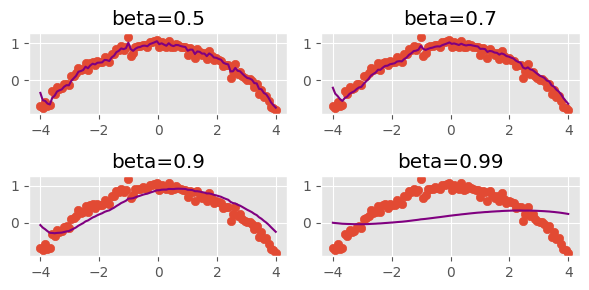

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(6, 3))
betas = [0.5, 0.7, 0.9, 0.99]
for beta, ax in zip(betas, axs.flatten()):
    ax.scatter(xs, ys)
    avg, res = 0, []
    for yi in ys:
        avg = beta * avg + (1 - beta) * yi
        res.append(avg)
    ax.plot(xs, np.array(res), color="purple")
    ax.set_title(f"beta={beta}")
fig.tight_layout()

This demonstrates how momentum can smooth out the loss surface.

In [10]:
class MomentumSGD(SGD):
    def __init__(self, params, lr, wd=0, mom=0.9):
        super().__init__(params, lr, wd)
        self.mom = mom

    def opt_step(self, p):
        grad_avg = getattr(p, "grad_avg", torch.zeros_like(p.grad))

        # This is slight more sophisticated than the MomentumCB because
        # it wasn't apropriately weighting the existing gradients
        p.grad_avg = grad_avg * self.mom + p.grad * (1 - self.mom)

        p -= p.grad_avg * self.lr

Let's try this on FashionMNIST

MulticlassAccuracy,loss,epoch,train
0.803,0.549,0,train
0.590,1.788,0,eval
0.857,0.395,1,train
0.851,0.411,1,eval
0.880,0.325,2,train
0.866,0.383,2,eval


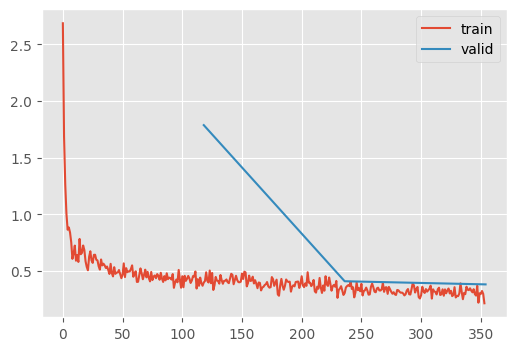

In [11]:
train(
    get_kaiming_initalized_model(),
    lr=1.25,  # 👈 learning rate can be WAY up here
    opt_func=MomentumSGD,
)

:::{.callout-tip}
## Tangent
Jeremy goes on a tangent here and discusses batch sizes. In theory, larger batch sizes represent a more accurate reprentation of the loss surface. But they also imply that there are fewer update steps, which is bad! Supposedly, Yan LeCunn (originally) thought that the ideal batch size is one, whereas the norm these days is to have a batch size of millions.
:::

## RMSProp

Momentum can be "aggressive" for some finicky architectures. `RMSProp` is a historically interesting architecture that can be used instead. This was an optimization algorithm debuted in a Coursera by Hinton. It was never published.

The algorithm trains models by updating weights with the gradient divided by an **exponentially weighted average of the square of the gradients.** Large squared gradients imply large variances, so this ensure gives each parameter a chance to shine 🌟 In other words, this allows the network to take larger steps in directions where gradients are consistently small, and smaller steps in directions where gradients are fluctuating or large. 

In [12]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0.0, sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom, self.eps = sqr_mom, eps

    def opt_step(self, p):
        # Note that Jeremy initializes the squared average as that of the current
        # gradient, instead of 0. Otherwise, p.sqr_avg.sqrt() + self.eps is a
        # very large value and the initial learning rate is very high
        sqr_avg = getattr(p, "sqr_avg", p.grad**2)
        #                                    vvvvvvvvv
        p.sqr_avg = sqr_avg * self.sqr_mom + p.grad**2 * (1 - self.sqr_mom)
        p -= self.lr * p.grad / (p.sqr_avg.sqrt() + self.eps)

How does this do on FashionMNIST?

MulticlassAccuracy,loss,epoch,train
0.780,0.635,0,train
0.814,0.536,0,eval
0.855,0.387,1,train
0.827,0.513,1,eval
0.869,0.348,2,train
0.822,0.521,2,eval


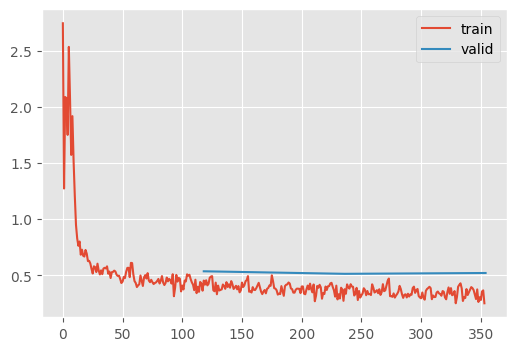

In [13]:
train(get_kaiming_initalized_model(), lr=1e-2, opt_func=RMSProp)

Honestly, not that good in practice -- at least on its own. That's why we usually see:

## Adam

RMSProp and momentum are usually seen together in the Adam optimizer.

Keep in mind that $\beta$ terms `beta1` and `beta2` are just momentum and squared momentum! 

In [14]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0.0, beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps

    def opt_step(self, p):
        if not hasattr(p, "avg"):
            p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, "sqr_avg"):
            p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1 * p.avg + (1 - self.beta1) * p.grad

        # For the first minibatch, the momentum is 0, so the gradient
        # should be quite small. However, we know this is the case and
        # we can adjust for it because we know how far from 0 it should
        # be -- i.e., $(beta_1)^2$. Therefore, we can divide by 1 minus
        # this term to increase the average. Note that as i increases,
        # the unbiased avg approaches the original avg
        unbias_avg = p.avg / (1 - (self.beta1 ** (self.i + 1)))

        p.sqr_avg = self.beta2 * p.sqr_avg + (1 - self.beta2) * (p.grad**2)

        # Same idea as above
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2 ** (self.i + 1)))

        # Finally, we perform the learning rate modulation for momentum and
        # RMSProp
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

MulticlassAccuracy,loss,epoch,train
0.824,0.490,0,train
0.852,0.430,0,eval
0.874,0.346,1,train
0.867,0.386,1,eval
0.888,0.302,2,train
0.868,0.371,2,eval


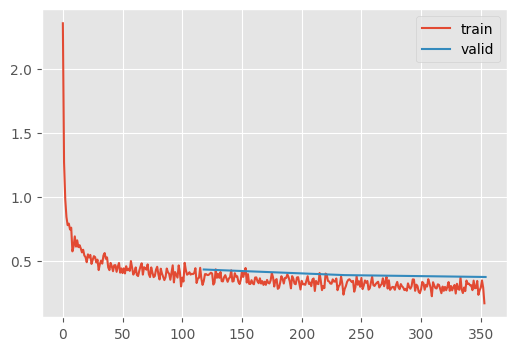

In [15]:
train(get_kaiming_initalized_model(), lr=1e-2, opt_func=Adam)

## Schedulers

Decreasing the learning rate over time is thought to help with convergence by allowing the network to explore grooves in the loss surface.

Here are the built-in optimizers:

In [39]:
[m for m in dir(lr_scheduler) if m != "EPOCH_DEPRECATION_WARNING" and m[0].isupper()]

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'ExponentialLR',
 'LRScheduler',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'PolynomialLR',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR']

We'll need to tweak the Learner API to incorporate schedulers.

In [36]:
opt = torch.optim.SGD(model.parameters(), lr=1e-1)
param = next(iter(model.parameters()))
st = opt.state[param]
st

{}

PyTorch stores parameter state in the optimizer, similarly to how we stored state directly in the tensors.

```python
grad_avg = getattr(p, "grad_avg", torch.zeros_like(p.grad))
p.grad_avg = grad_avg * self.mom + p.grad * (1 - self.mom)
p -= p.grad_avg * self.lr
```

We can also group state in "parameter groups"

In [18]:
opt

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [19]:
opt.param_groups[0].keys()

dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov', 'maximize', 'foreach', 'differentiable'])

We can configure out learning rate scheduler like so

In [20]:
lr_scheduler.CosineAnnealingLR?

Init signature:
lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max,
    eta_min=0,
    last_epoch=-1,
    verbose=False,
)
Docstring:     
Set the learning rate of each parameter group using a cosine annealing
schedule, where :math:`\eta_{max}` is set to the initial lr and
:math:`T_{cur}` is the number of epochs since the last restart in SGDR:

.. math::
    \begin{aligned}
        \eta_t & = \eta_{min} + \frac{1}{2}(\eta_{max} - \eta_{min})\left(1
        + \cos\left(\frac{T_{cur}}{T_{max}}\pi\right)\right),
        & T_{cur} \neq (2k+1)T_{max}; \\
        \eta_{t+1} & = \eta_{t} + \frac{1}{2}(\eta_{max} - \eta_{min})
        \left(1 - \cos\left(\frac{1}{T_{max}}\pi\right)\right),
        & T_{cur} = (2k+1)T_{max}.
    \end{aligned}

When last_epoch=-1, sets initial lr as lr. Notice that because the schedule
is defined recursively, the learning rate can be simultaneously modified
outside this scheduler by other operators. If the learning rate is set
solely by this scheduler, the

In [21]:
n_batches = 100
sched = lr_scheduler.CosineAnnealingLR(opt, n_batches)

In [22]:
def plot_scheduler(sched, n_steps):
    fig, ax = plt.subplots()
    lrs = []
    lrs.append(sched.get_last_lr())
    for _ in range(n_batches):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
        ax.plot(lrs)
    ax.set(xlabel="Time", ylabel="LR");

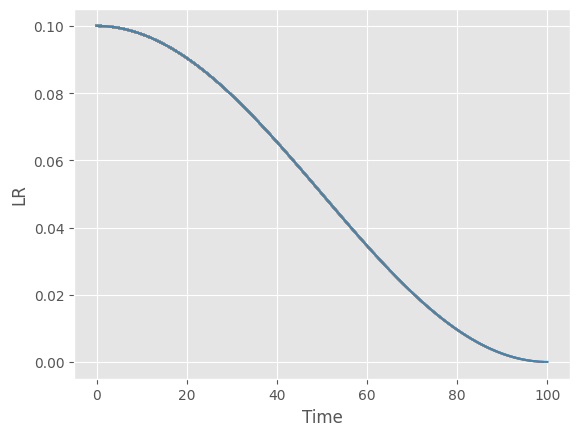

In [23]:
plot_scheduler(sched, n_steps=n_batches)

Let's write this as a callback

In [24]:
# |export
class BaseSchedulerCB(Callback):
    """Base callback class for schedulers"""

    def __init__(self, scheduler_f, **kwargs):
        self.scheduler_f = scheduler_f
        self.sched_kwargs = kwargs
        self.sched = None

    def before_fit(self, learn):
        self.sched = self.scheduler_f(learn.opt, **self.sched_kwargs)

    def _step(self, learn):
        if learn.training:
            self.sched.step()

In [25]:
# |export
class BatchSchedulerCB(BaseSchedulerCB):
    """Step the scheduler every batch"""

    def after_batch(self, learn):
        self._step(learn)

In [26]:
# |export
class RecorderCB(Callback):
    """Record internal state values at each batch."""

    def __init__(self, **d):
        self.d = d
        self.learn = None

    def before_fit(self, learn):
        self.learn = learn
        self.recs = {k: [] for k in self.d}
        self.pg = learn.opt.param_groups[0]

    def after_batch(self, learn):
        if not learn.training:
            return
        for k, v in self.d.items():
            self.recs[k].append(v(self))

    def plot(self, **kwargs):
        n = len(self.recs)
        if "figsize" not in kwargs:
            K = 3
            kwargs["figsize"] = (K * n, K)
        fig, axes = plt.subplots(1, n, **kwargs)
        if n > 1:
            axes = axes.flatten()
        else:
            axes = [axes]
        for ax, (k, v) in zip(axes, self.recs.items()):
            ax.plot(v, label=k)
            ax.legend()
        fig.tight_layout()

MulticlassAccuracy,loss,epoch,train
0.822,0.493,0,train
0.843,0.430,0,eval
0.878,0.332,1,train
0.868,0.359,1,eval
0.896,0.283,2,train
0.877,0.335,2,eval


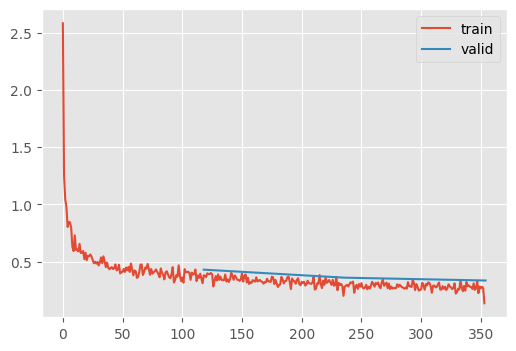

In [27]:
n_epochs = 3
dls = fashion_mnist(512)
T_max = len(dls["train"]) * n_epochs
scheduler = BatchSchedulerCB(lr_scheduler.CosineAnnealingLR, T_max=T_max)
recorder = RecorderCB(lr=g("pg.lr"))
train(
    get_kaiming_initalized_model(),
    1e-2,
    n_epochs,
    opt_func=torch.optim.Adam,
    cbs=[scheduler, recorder],
)

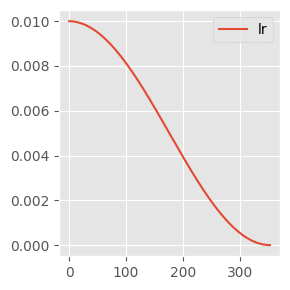

In [28]:
recorder.plot()

Another trick to improve training dynamics is to start with a warmup, as in the [1cycle policy](https://arxiv.org/pdf/1803.09820.pdf). This is because high learning rate in the initial phase of poorly initialized models can lead to the dead units issue explored earlier.

In [29]:
lr_scheduler.OneCycleLR?

Init signature:
lr_scheduler.OneCycleLR(
    optimizer,
    max_lr,
    total_steps=None,
    epochs=None,
    steps_per_epoch=None,
    pct_start=0.3,
    anneal_strategy='cos',
    cycle_momentum=True,
    base_momentum=0.85,
    max_momentum=0.95,
    div_factor=25.0,
    final_div_factor=10000.0,
    three_phase=False,
    last_epoch=-1,
    verbose=False,
)
Docstring:     
Sets the learning rate of each parameter group according to the
1cycle learning rate policy. The 1cycle policy anneals the learning
rate from an initial learning rate to some maximum learning rate and then
from that maximum learning rate to some minimum learning rate much lower
than the initial learning rate.
This policy was initially described in the paper `Super-Convergence:
Very Fast Training of Neural Networks Using Large Learning Rates`_.

The 1cycle learning rate policy changes the learning rate after every batch.
`step` should be called after a batch has been used for training.

This scheduler is not chai

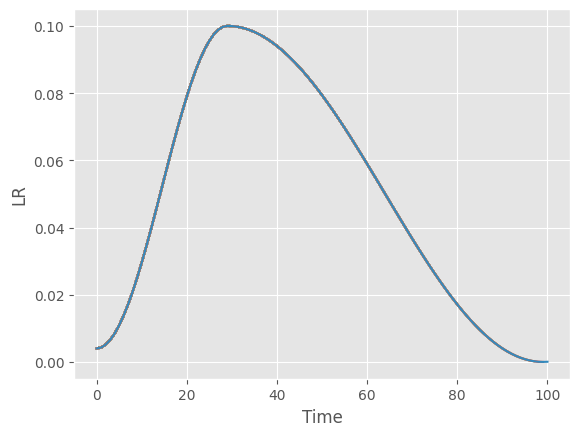

In [30]:
plot_scheduler(lr_scheduler.OneCycleLR(opt, max_lr=0.1, total_steps=100), 100)

Ultimately, tricks like batch norm and OneCycle are unneccesary if the model is initialized apropriately. These papers are excellent guides to doing so:

- For **ResNets**: [Fixup Initialization: Residual Learning Without Normalization](https://arxiv.org/abs/1901.09321)

> Normalization layers are a staple in state-of-the-art deep neural network architectures. They are widely believed to stabilize training, enable higher learning rate, accelerate convergence and improve generalization, though the reason for their effectiveness is still an active research topic. In this work, we challenge the commonly-held beliefs by showing that none of the perceived benefits is unique to normalization. Specifically, we propose fixed-update initialization (Fixup), an initialization motivated by solving the exploding and vanishing gradient problem at the beginning of training via properly rescaling a standard initialization. We find training residual networks with Fixup to be as stable as training with normalization -- even for networks with 10,000 layers. Furthermore, with proper regularization, Fixup enables residual networks without normalization to achieve state-of-the-art performance in image classification and machine translation. 
  
- For **Transformers**: [Improving Transformer Optimization Through Better Initialization](https://www.cs.toronto.edu/~mvolkovs/ICML2020_tfixup.pdf)

> The Transformer architecture has achieved considerable success recently; the key component of the Transformer is the attention layer that enables the model to focus on important regions within an input sequence. Gradient optimization with attention layers can be notoriously difficult requiring tricks such as learning rate warmup to prevent divergence. As Transformer models are becoming larger and more expensive to train, re- cent research has focused on understanding and improving optimization in these architectures. In this work our contributions are two-fold: we first investigate and empirically validate the source of optimization problems in the encoder-decoder Transformer architecture; we then propose a new weight initialization scheme with theoretical justi- fication, that enables training without warmup or layer normalization. Empirical results on public machine translation benchmarks show that our approach achieves leading accuracy, allowing to train deep Transformer models with 200 layers in both encoder and decoder (over 1000 atten- tion/MLP blocks) without difficulty.

:::{.callout-tip}
## Warning
Over time, the community learn to initialize models correctly. It's difficult! Most researchers don't realize they don't need batch norm or warmup if the initialization is correct. Don't be like most researchers!
:::

In [4]:
# |export
def train_1cycle(model, lr=1e-2, n_epochs=3, extra_cbs=[]):
    dls = fashion_mnist(512)
    T_max = len(dls["train"]) * n_epochs
    scheduler = BatchSchedulerCB(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=T_max)
    recorder = RecorderCB(lr=g("pg.lr"), mom=g("pg.betas.0"))
    cbs = [scheduler, recorder, stats, *extra_cbs]
    try:
        stats = StoreModuleStatsCB(mods=model.layers)
    except AttributeError:
        stats = None
    else:
        cbs.append(stats)
    train(
        model,
        lr,
        n_epochs,
        opt_func=torch.optim.AdamW,
        cbs=cbs,
    )
    return recorder, stats

MulticlassAccuracy,loss,epoch,train
0.727,0.777,0,train
0.837,0.482,0,eval
0.870,0.357,1,train
0.868,0.361,1,eval
0.895,0.285,2,train
0.884,0.320,2,eval


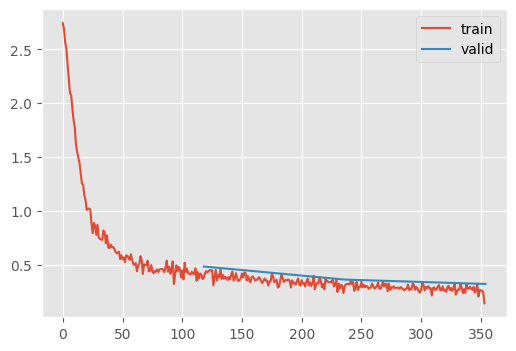

In [32]:
recorder, _ = train_1cycle(get_kaiming_initalized_model())

Notice that the learning rate schedule is negatively correlated to the momentum. The idea is that as the network approaches a stable training dynamic, the momentum is less neccesary. 

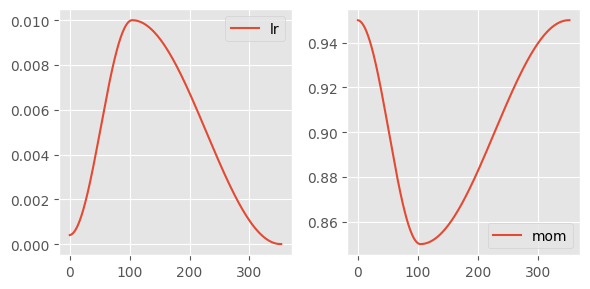

In [33]:
recorder.plot()

## Achieving 90% accuracy

Let's simply increase the maximum learning rate and the training duration with all the improvements we've explored in this notebook

MulticlassAccuracy,loss,epoch,train
0.792,0.578,0,train
0.798,0.559,0,eval
0.843,0.428,1,train
0.831,0.479,1,eval
0.874,0.339,2,train
0.866,0.377,2,eval
0.893,0.288,3,train
0.883,0.328,3,eval
0.909,0.247,4,train
0.894,0.294,4,eval


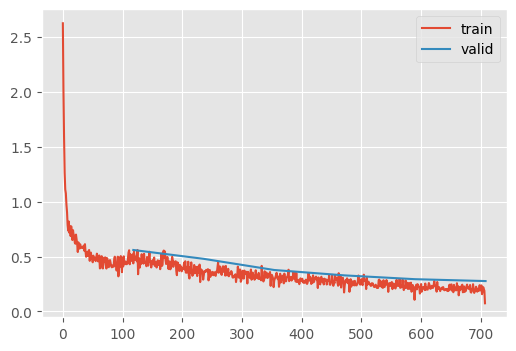

In [34]:
train_1cycle(get_kaiming_initalized_model(), lr=5e-2, n_epochs=6);

90% accuracy 🎉🎉🎉

In [6]:
#| hide
import nbdev

nbdev.nbdev_export()